<h1>Who's That Pokemon?</h1>

I wished to test how well an image classification architecture could work on images scraped off the web, such that the network would be capable of identifying the different pokemon classes.

I'll use three simple Pokemon for this scenario: <i>Charmander, Bulbasaur </i>and <i>Squirtle</i>.

Importing torch, torchvision and matplotlib below:

In [95]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from PIL import Image

<h3>Training Data:</h3>
<p>I scraped about 200 images for each pokemon from the web, using Mozilla's Image Downloader extension. Chrome's Fatkun is also a reasonable option, for Chrome users. From those 200, I manually deleted over a hundred images, which did not fulfill my category of being <i>an rgb image with only the specific pokemon being present.</i></p>
<p>End result:</p>
<ul>
    <li>
        Charmander: 75 images
    </li>
    <li>
        Bulbasaur: 76 images
    </li>
    <li>
        Squirtle: 79 images
    </li>
</ul>
Total: 230 images

In [2]:
data_dir = 'pokemondata'

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(128),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()])

train_data = datasets.ImageFolder(data_dir, transform=train_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=25, shuffle=True)

In [119]:
retransform = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = retransform(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

Let's take a look at a random image from the training set.

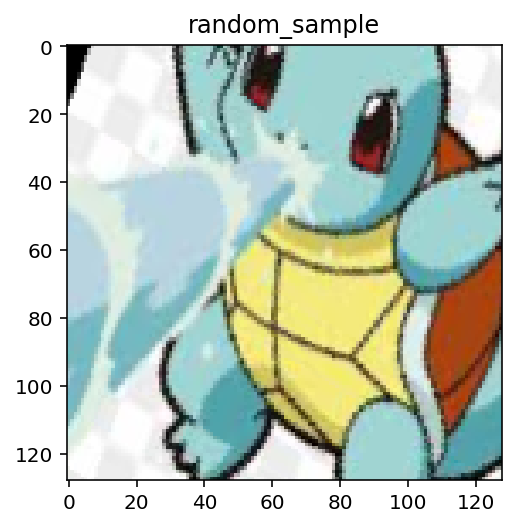

In [136]:
image_batch=iter(trainloader)
img,lab=next(image_batch)
imshow(img[0],'random_sample')

<h3>Transfer Learning:</h3> <p>We'll use the pretrained Densenet121 to speed up the learning process.

In [3]:
model = models.densenet121(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\User/.cache\torch\checkpoints\densenet121-a639ec97.pth
100%|█████████████████████████████████████████████████████████████████| 32342954/32342954 [00:19<00:00, 1690710.91it/s]


Let's take a look at densenet121:

In [97]:
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

)


We don't need to train the pretrained parameters, so we'll freeze those.<p> We'll add fully connected layers which we'll train instead; this will be our classifier.

In [44]:
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 3)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

We'll use GPU if available, or train on CPU. Due to the relatively small size of the database, as well as the small 128x128 resolution, it works pretty quickly on CPU as well.

In [45]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet121(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 3),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device);

In [46]:
epochs = 1
steps = 0
running_loss = 0
print_every=3
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:         
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}..")
            running_loss = 0

Epoch 1/1.. Train loss: 1.385..
Epoch 1/1.. Train loss: 1.052..
Epoch 1/1.. Train loss: 0.665..


<h3>Testing:</h3>
<p>Time to test the model.</p>

In [137]:
test_transform = transforms.Compose([transforms.Resize(128),
                                transforms.ToTensor()])
                               
def image_loader(image_path):
    image=Image.open(image_path)
    image=test_transform(image).unsqueeze(0)
    return image.to(device, torch.float)

In [140]:
test_1 = image_loader('pokemontest/a1.jpeg')
test_2 = image_loader('pokemontest/b1.jpeg')
test_3 = image_loader('pokemontest/c1.jpeg')

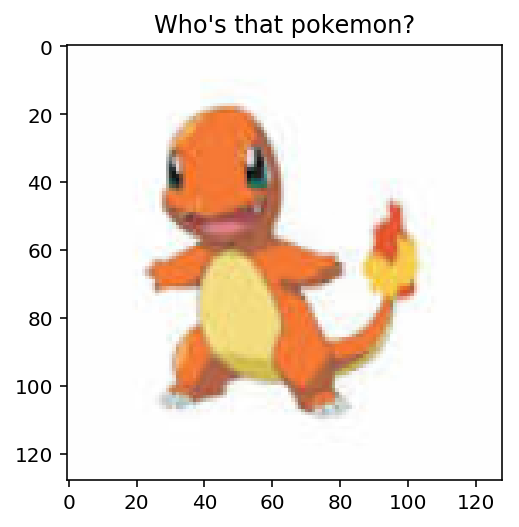

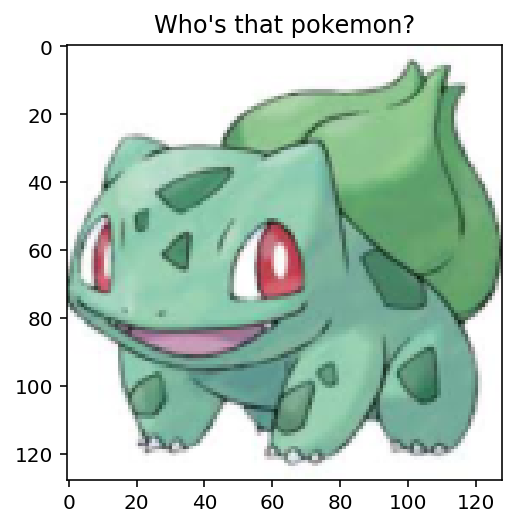

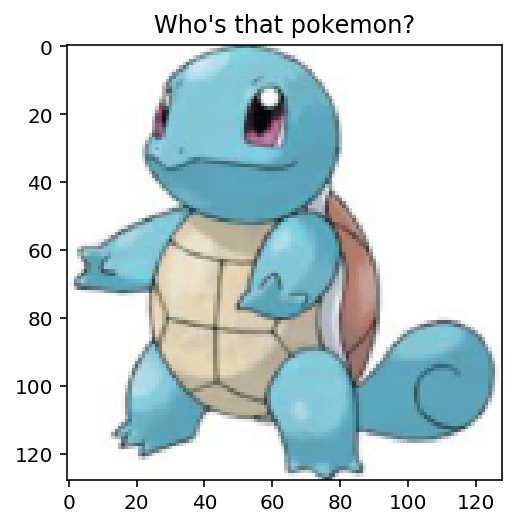

In [141]:
plt.ion()
plt.figure()
imshow(test_1, title='Who\'s that pokemon?')
plt.figure()
imshow(test_2, title='Who\'s that pokemon?')
plt.figure()
imshow(test_3, title='Who\'s that pokemon?')

In [143]:
model.eval()
with torch.no_grad():
    test_1= test_1.to(device)
    test_2= test_2.to(device)
    test_3= test_3.to(device)
    logps1 = model.forward(test_1)
    logps2 = model.forward(test_2)
    logps3 = model.forward(test_3)
    ps1 = torch.exp(logps1)
    ps2 = torch.exp(logps2)
    ps3 = torch.exp(logps3)
    top_p1, top_class1 = ps1.topk(1, dim=1)
    top_p2, top_class2 = ps2.topk(1, dim=1)
    top_p3, top_class3 = ps3.topk(1, dim=1)
#model.train()                

In [165]:
print(train_data.class_to_idx)
print('Probability - Classes identified:')
print(top_p1,top_class1)
print(top_p2,top_class2)
print(top_p3,top_class3)

{'bulbasaur': 0, 'charmander': 1, 'squirtle': 2}
Probability - Classes identified:
tensor([[0.8625]]) tensor([[1]])
tensor([[0.9270]]) tensor([[0]])
tensor([[0.7625]]) tensor([[2]])


<h3>Results:</h3> <p>The first class is 1 - Charmander. The second one is 0 - Bulbasaur. The third is predicted as 2 - Squirtle. All three were correctly identified.